# Gaussian Clustering with Expectation Maximization

Let's generate two gaussian clusters and try seperating these into two seperate clusters of data. These clusters can represent any datatype, however the key in this notebook is to introduce various Bayesian methods of seperating them.

Here we will introduce the Expectation Maximization (EM) algorithm. First let's generate some artificial clusters to try and cluster.

In this example we will assume we know the number of overall clusters in our dataset to begin with. If we don't know the number of clusters we can use an additional parameter and maximise as we would usually. This will be covered seperately.

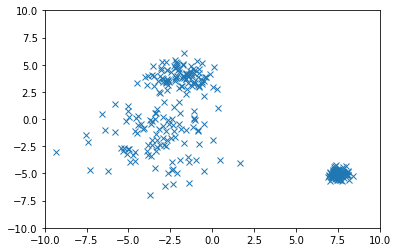

In [89]:
import numpy
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib

mean_1 = [-2.0,4.0]
mean_2 = [-3.5,-2.0]
mean_3 = [7.5,-5.0]

cov_1 = [[1,0],
         [0,1]]
cov_2 = [[4,0],
         [0,4]]
cov_3 = [[0.1,0],
         [0,0.1]]
samples = 100

dataset_1 = [numpy.random.multivariate_normal(mean_1,cov_1) for i in range(samples)]
dataset_2 = [numpy.random.multivariate_normal(mean_2,cov_2) for i in range(samples)]
dataset_3 = [numpy.random.multivariate_normal(mean_3,cov_3) for i in range(samples)]
dataset_total = numpy.concatenate((dataset_1, dataset_2, dataset_3))

plt.plot(dataset_total[:,0],dataset_total[:,1],'x')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

# EM Algorithm

The expectation maximization algorithm is split into two steps:

1) Expectation step: calculate the probability that a point belongs to each cluster. This is done for every data point and every proposed cluster.

2) Maximisation step: maximise the likelihood so that we converge on the correct means and variances for each cluster.



In [93]:
from scipy.stats import multivariate_normal as mvn

def covariancef(X,Y,mean_x,mean_y,N):
    sum = 0.0
    j = 0
    for x,y in zip(X,Y):
        sum += ((x - mean_x)*(y - mean_y))
        j += 1
    return sum/N


## Index key:
# i - classes
# j - data

def expectation_step(data,means,sigmas,no_classes,no_data):
   
    r = numpy.zeros(shape=(no_classes,no_data))
    for i in range(no_classes):
        for j in range(no_data):
            denom = 0.0
            for ii in range(no_classes):
                denom += mvn.pdf(data[j],means[ii],numpy.diagflat(numpy.exp(sigmas[ii])))
            r[i,j] = mvn.pdf(data[j],means[i],numpy.diagflat(numpy.exp(sigmas[i])))/denom
    return r

def maximization_step(data,r,no_classes,no_data):
    
    # What we are looking to maximise the likelihood of
    means = numpy.zeros(shape=(no_classes,2))
    sigmas = numpy.zeros(shape=(no_classes,2))
    
    # Calculate Weights
    weights = numpy.zeros(shape=(no_classes,no_data))
    for i in range(no_classes):
        for j in range(no_data):
            weights[i,j] = r[i,j]/numpy.sum(r[i,:])
    # Calculate new cluster parameters.
    for i in range(no_classes):
        for j in range(no_data):
            #print(weights[i,j]*data[i,j])
            
            means[i,:] += weights[i,j]*data[j,:]
        sigmas[i,:] = numpy.log(numpy.sum(weights[i,:]) * covariancef(data[i,:],data[i,:],means[i],means[i],no_data))
    return means,sigmas

# General Parameters
max_iters=20
no_cent = 3

# For the E-Step:
mean_expec = numpy.zeros(shape=(no_cent,dataset_total.shape[0],2))
var_expec = numpy.zeros(shape=(no_cent,dataset_total.shape[0],2))

# For the M-Step:
mu_chain = numpy.zeros(shape=(no_cent, max_iters,2))
var_chain = numpy.zeros(shape=(no_cent, max_iters,2))
mu_chain[0,:,:] = 1
mu_chain[1,:,:] = -1
mu_chain[2,:,0] = 5
mu_chain[2,:,1] = -2
var_chain[:,:,:] = 1


# Find Clusters
for i in range(max_iters-1):
    r = expectation_step(dataset_total, mu_chain[:,i],var_chain[:,i],no_cent,dataset_total.shape[0])
    new_means,new_sigmas = maximization_step(dataset_total,r,no_cent,dataset_total.shape[0])
    mu_chain [:,i+1,:] = new_means
    var_chain [:,i+1,:] = new_sigmas
                          
                     
                     
                

Print our cluster means and covariances:

In [94]:
#Cluster Means
print(mu_chain[:,-1,:])

#Cluster Variances (some numerical instability here?)

print(1/numpy.sqrt(numpy.exp(var_chain[:,-1,:])))

[[-1.88929343  3.8676201 ]
 [-3.31021483 -1.82701196]
 [ 7.47142917 -5.02856056]]
[[ 2.7468022   4.35467601]
 [ 2.35881207  3.17256709]
 [ 1.81281667  1.78150145]]


## Split data into clusters / Plot

Next is to use our derived means and covariance matrices to split the data into our clusters and draw our clusters.

We'll run the expectation step one last time to get the probabilities of a point belonging to a cluster. 

(3, 300)
[[ 1.00717232  0.00562578]
 [ 0.00562578  0.69665658]]
[[ 3.35859758  0.02156948]
 [ 0.02156948  3.62171437]]
[[ 0.42760262 -0.06181827]
 [-0.06181827  0.10772145]]


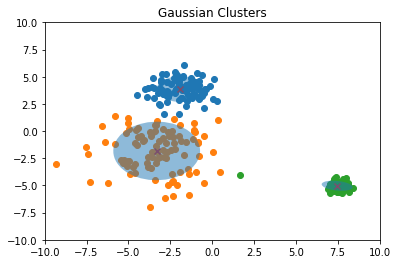

In [95]:
lastr = expectation_step(dataset_total, mu_chain[:,-1], var_chain[:,-1], no_cent,dataset_total.shape[0])
print(lastr.shape)
lastr[2,200:230]

cluster_locations = numpy.zeros(shape=dataset_total.shape[0])
cluster_locations = numpy.argmax(lastr,axis=0)

splot = plt.subplot(1,1,1)
# Seperate dataset into clusters, plot seperately.
for j in numpy.arange(no_cent):
    ind = numpy.where(cluster_locations==j)
    data = dataset_total[ind,:]
    data = data[0,:,:]
    ax = plt.scatter(data[:,0],data[:,1])
    cov = numpy.cov(data[:,0],data[:,1])
    print(cov)
    
    # Plot ellipses denoting covariance.    
    v,w = linalg.eigh(cov)
    v = 2. * numpy.sqrt(2.) * numpy.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = numpy.arctan(u[1]/u[0])
    angle = 180. * angle/numpy.pi
    
    ell = matplotlib.patches.Ellipse(mu_chain[j,-1,:],v[0],v[1],180. + angle)
    ell.set_clip_box(splot)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

# Plot cluster centres as cross.
plt.scatter(mu_chain[:,-1,0],mu_chain[:,-1,1],marker='x')    
plt.title("Gaussian Clusters")
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.show()